In [252]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
sns.set_style("dark")
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression,Ridge,Lasso
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from scipy.stats import gaussian_kde
# from sklearn.preprocessing import scale

## TODO: 

1. Predict age by using a combination of models and reconstruct train
2. Predict age in test set
2. Use SMOTE to balance the data
3. create models for classificatoin

## functions

In [206]:
a = [12,213,3,12,321,3]
if filter(lambda x: x>3200,a):
    print(a)
else:
    print("Dsadsa")

[12, 213, 3, 12, 321, 3]


In [207]:
def get_null_rows(df,att):   ###returns the inddices and and index of the column with the null values
    rel_locations = df[att].isnull().nonzero()[0]
    att_idx = (df.columns == att).nonzero()[0][0]
    return (rel_locations,att_idx)

In [208]:
# def get_best_model(initial_model,X,y,val_X=None,val_y=None,cv=5,params = None,has_val = True):
def get_best_model(initial_model,X,y,cv=5,params = None):
    model = GridSearchCV(initial_model,cv=cv,param_grid=params)
    model.fit(X,y)
#     if has_val:
#         predict = model.predict(val_X)
#         accuracy = (1. * np.sum(predict == val_y ) / len(val_y))
#         print "The accuracy of best model on validation is %f " %(accuracy)
#         print "Confusion matrix of best model on validation: \n",confusion_matrix(val_y,predict)
    return model.best_estimator_

## Get the data

In [209]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender = pd.read_csv("gender_submission.csv")

In [210]:
# y_train = train['Survived']
# train = train.drop(['Survived'],1) # justify dropping 'PassengerId','Name','Cabin','Ticket'


### Check - is data balanced? No..

number of survivors 0.3838383838383838
number of others 0.6161616161616161


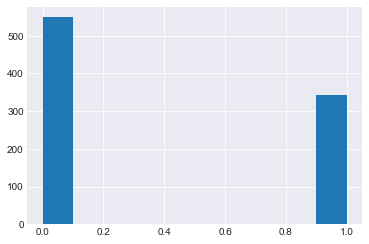

In [211]:
print("number of survivors" , np.sum(train['Survived'] == 1) * 1.0 / train['Survived'].size)
print("number of others" , np.sum(train['Survived'] == 0) * 1.0 / train['Survived'].size)

train['Survived'].hist()

In [212]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

there are:
        177 null values of Age, 
        687 null values of cabin and
        2 null values of embarked
            


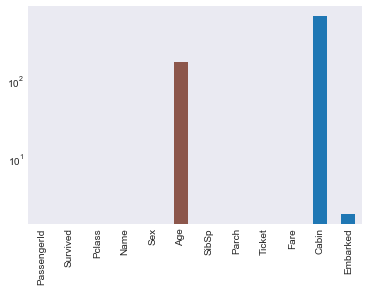

In [213]:
train.isnull().sum().plot('bar', logy = True)
print('''there are:
        %d null values of Age, 
        %d null values of cabin and
        %d null values of embarked
            ''' %(train['Age'].isnull().sum(),train['Cabin'].isnull().sum(),train['Embarked'].isnull().sum()))

### => Cabin has too many null values

In [214]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [215]:
len(train['Ticket'].unique())

681

'PassengerId','Name','Cabin','Ticket' are not enough informative

In [216]:
train = train.drop(['PassengerId','Name','Cabin','Ticket'],1)

In [217]:
print(train.columns) 
print(train.dtypes)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')
Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object


## converting Sex to binary variable

In [218]:
train['Sex'].unique()  #only male/female

array(['male', 'female'], dtype=object)

In [219]:
train['Sex'] = train['Sex'].map(lambda val: 1 if val =='male'  else 0 )

### checking embarked

In [220]:
np.where(train['Embarked'].isnull())

(array([ 61, 829], dtype=int64),)

In [221]:
print(train.iloc[[61,829]])

train.iloc[[61,829]]

     Survived  Pclass  Sex   Age  SibSp  Parch  Fare Embarked
61          1       1    0  38.0      0      0  80.0      NaN
829         1       1    0  62.0      0      0  80.0      NaN


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,0,38.0,0,0,80.0,NaN
829,1,1,0,62.0,0,0,80.0,NaN


In [222]:
train = train[~train['Embarked'].isnull().values]
# train = train[~train['Embarked'].isnull()]

In [223]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [224]:
embarked = train['Embarked'].unique()
embarked

array(['S', 'C', 'Q'], dtype=object)

([<matplotlib.axis.XTick at 0x18e0c748>,
 <a list of 3 Text xticklabel objects>)

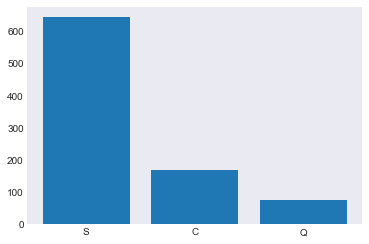

In [225]:
plt.bar(range(len(embarked)),train['Embarked'].value_counts())
plt.xticks(range(len(embarked)), embarked)

In [226]:
pd.crosstab(train['Survived'],train['Embarked'])  #most of the people didn't survived! 'C' and 'S' are more informative

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


### converting 'Embarked' to dummy variables

In [227]:
# def att_to_dummy(df,att,unique_vals,new_vals):
#     for i in range(len(unique_vals)):
#         df[new_vals[i]] = (df[att] == unique_vals[i]) + 0
#     df = df.drop(att,axis = 1)
#     return df

# new_vals1 = ['Embarked_S','Embarked_C','Embarked_Q']
# train = att_to_dummy(train,'Embarked',embarked,new_vals1)

In [228]:
train = pd.concat([train, pd.get_dummies(train['Embarked'], prefix='embarked')], axis=1)
train.drop('Embarked', axis=1, inplace=True)

### dealing with Pclass

([<matplotlib.axis.XTick at 0x18db6240>,
 <a list of 3 Text xticklabel objects>)

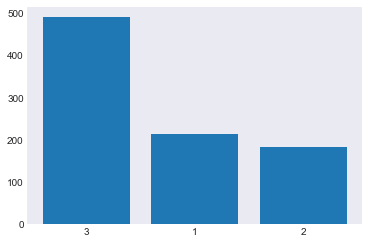

In [229]:
pclass = train['Pclass'].unique()
plt.bar(range(len(pclass)),train['Pclass'].value_counts())
plt.xticks(range(len(pclass)), pclass)

In [230]:
# new_vals2 = ['Pclass_3','Pclass_1','Pclass_2']
# train = att_to_dummy(train,'Pclass',pcalss,new_vals2)

In [231]:
train = pd.concat([train, pd.get_dummies(train['Pclass'], prefix='class')], axis=1)
train.drop('Pclass', axis=1, inplace=True)

In [232]:
train.head()

,Survived,Sex,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3
0,0,1,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,0,26.0,0,0,7.9250,0,0,1,0,0,1
3,1,0,35.0,1,0,53.1000,0,0,1,1,0,0
4,0,1,35.0,0,0,8.0500,0,0,1,0,0,1


## Parch

In [233]:
pd.crosstab(train['Survived'],train['Parch'], margins=True)

Parch,0,1,2,3,4,5,6,All
Survived,,,,,,,,
0,445,53,40,2,4,4,1,549
1,231,65,40,3,0,1,0,340
All,676,118,80,5,4,5,1,889


In [234]:
pd.crosstab(train['Survived'],train['Parch'], normalize='columns')

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,0.658284,0.449153,0.5,0.4,1.0,0.8,1.0
1,0.341716,0.550847,0.5,0.6,0.0,0.2,0.0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


([array([231.,  65.,  40.,   3.,   0.,   1.]),
  array([676., 118.,  80.,   5.,   4.,   6.])],
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 2 Lists of Patches objects>)

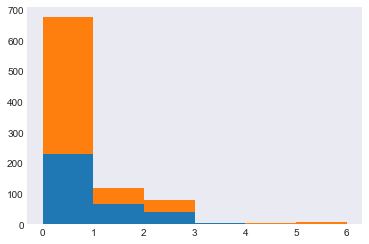

In [235]:
is_survived = train['Survived'] == 1
plt.hist([train[is_survived]['Parch'], train[~is_survived]['Parch']], stacked=True, bins=range(7))

(array([676., 118.,  80.,   5.,   4.,   6.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

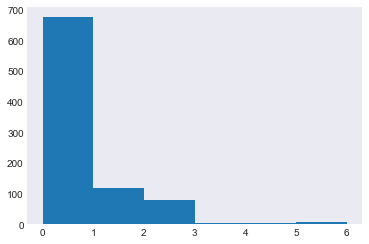

In [236]:
plt.hist(train['Parch'],bins=range(7))

# we stopped here 2018-03-28

In [237]:
def information_gain(df,att,y,partition):
    Hy = calc_IG(df,y)
    tmp = df[df[att] <= partition[0]].filter([att,y])
    Px = 1. * len(tmp[y]) / len(df[y])
    H_y_x = calc_IG(tmp,y,Px)
    prev_att = partition[0]
    for curr_att in partition[1:-1]:
        tmp = df[(df[att] <= curr_att) & (df[att] > prev_att)].filter([att,y])
        Px = 1. * len(tmp[y]) / len(df[y])
        H_y_x += calc_IG(tmp,y,Px)
        prev_att = curr_att
    tmp = df[df[att] >= partition[-1]].filter([att,y])
    Px = 1. * len(tmp[y]) / len(df[y])
    H_y_x += calc_IG(tmp,y,Px)
    return Hy - H_y_x  

In [238]:
def calc_IG(df,y,Px = None):
    N = len(df[y])
    Py = (df[y] == 1).sum() * 1.0 / N
    if Py == 1 or Py == 0:
        return 0
    if Px:
        return - Px * Py * np.log2(Py) - Px *(1-Py) * np.log2((1-Py))
    return - Py * np.log2(Py) - (1-Py) * np.log2((1-Py))

0.01577756071262515
0.01709312877099889
0.019430573092410808
0.02281066557942013
0.023699103606419802
0.024025868573183895


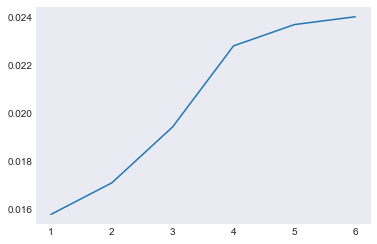

In [239]:
partitions = [[0,1],[0,1,2],[0,1,2,3],[0,1,2,3,4],[0,1,2,3,4,5],[0,1,2,3,4,5,6]]
res =[]
for i,partition in enumerate(partitions):
    res.append(information_gain(train,'Parch','Survived',partition))
    print(res[i])
plt.plot(range(1,len(res)+1),res) #split by option 4 - steepest slope

In [240]:
def split_to_ranges(df,column,partition):
    df[column+' <= '+str(partition[0])] = (df[column] <= partition[0]) + 0
    df[str(partition[1]) +'< '+column +' < '+str(partition[-1])] = ((df[column] > partition[0]) & (df[column] < partition[-1])) + 0
#     count = 1
#     for part in partition[1:-1]:
#         df[str(partition[count-1]) +'< '+column +' <= '+str(partition[count])] = ((df[column] <= partition[count]) & (df[column] > partition[count-1])) + 0
#         count += 1
        
    df[column+' >= '+str(partition[-1])] = (df[column] >= partition[-1]) + 0

In [241]:
split_to_ranges(train,'Parch',[0,1,2,3,4])
train = train.drop(['Parch'],axis=1)

In [242]:
print(train['Parch <= 0'].value_counts())
print(train['Parch >= 4'].value_counts())
print(train['1< Parch < 4'].value_counts())

1    676
0    213
Name: Parch <= 0, dtype: int64
0    879
1     10
Name: Parch >= 4, dtype: int64
0    686
1    203
Name: 1< Parch < 4, dtype: int64


In [243]:
print(train['SibSp'].unique())
pd.crosstab(train['Survived'],train['SibSp'])

[1 0 3 4 2 5 8]


SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,398,97,15,12,15,5,7
1,208,112,13,4,3,0,0


(array([606., 209.,  28.,  16.,  18.,   5.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

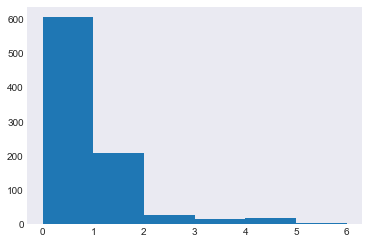

In [244]:
plt.hist(train['SibSp'],bins=range(7))

0.009952927880859663
0.02295553715392007
0.029815515225601774
0.031223120613191324
0.03388843469419023
0.03388843469419023


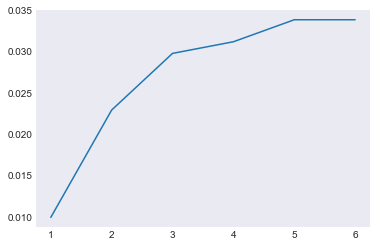

In [245]:
partitions = [[0,1],[0,1,2],[0,1,2,3],[0,1,2,3,4],[0,1,2,3,4,5],[0,1,2,3,4,5,8]]
res =[]
for i,partition in enumerate(partitions):
    res.append(information_gain(train,'SibSp','Survived',partition))
    print(res[i])
plt.plot(range(1,len(res)+1),res) #split by option 3 - steepest slope

In [247]:
split_to_ranges(train,'SibSp',[0,1,2,3])
train =train.drop(['SibSp'],axis=1)

In [250]:
train.head()

,Survived,Sex,Age,Fare,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,Parch <= 0,1< Parch < 4,Parch >= 4,SibSp <= 0,1< SibSp < 3,SibSp >= 3
0,0,1,22.0,7.2500,0,0,1,0,0,1,1,0,0,0,1,0
1,1,0,38.0,71.2833,1,0,0,1,0,0,1,0,0,0,1,0
2,1,0,26.0,7.9250,0,0,1,0,0,1,1,0,0,1,0,0
3,1,0,35.0,53.1000,0,0,1,1,0,0,1,0,0,0,1,0
4,0,1,35.0,8.0500,0,0,1,0,0,1,1,0,0,1,0,0


### dealing with Fare

In [249]:
train['Fare'].isnull().sum()

0

(array([ 732.,  104.,   31.,    2.,   11.,    6.,    0.,    0.,    0.,    3.]),
 array([   0.     ,   51.23292,  102.46584,  153.69876,  204.93168,
         256.1646 ,  307.39752,  358.63044,  409.86336,  461.09628,
         512.3292 ]),
 <a list of 10 Patch objects>)

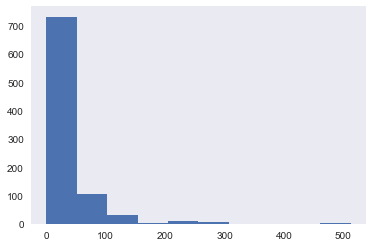

In [42]:
plt.hist(train['Fare'])

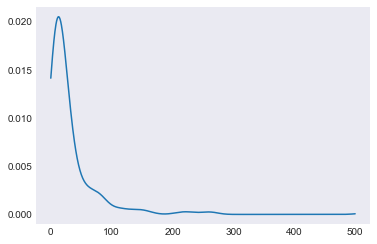

In [262]:
xs = np.linspace(0, 500, 889)
plt.plot(xs, gaussian_kde(train['Fare']).evaluate(xs))

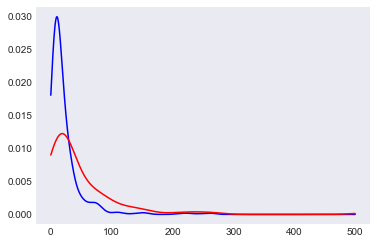

In [271]:
plt.plot(xs, gaussian_kde(train[train['Survived']==0]['Fare']).evaluate(xs), c='blue')  # not survived
plt.plot(xs, gaussian_kde(train[train['Survived']==1]['Fare']).evaluate(xs), c='red')   # survived

In [276]:
train[train['Survived']==0]['Fare'].describe()

count    549.000000
mean      22.117887
std       31.388207
min        0.000000
25%        7.854200
50%       10.500000
75%       26.000000
max      263.000000
Name: Fare, dtype: float64

In [277]:
train[train['Survived']==1]['Fare'].describe()

count    340.000000
mean      48.209498
std       66.748773
min        0.000000
25%       12.443750
50%       26.000000
75%       56.946900
max      512.329200
Name: Fare, dtype: float64

# Stopped here at 2018-05-17

32.0966808774
14.4542


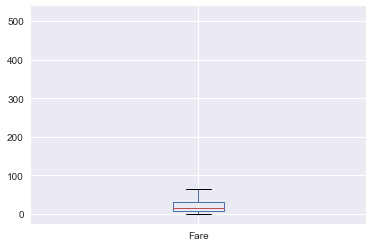

In [43]:
train.boxplot(column='Fare')
print(np.mean(train['Fare'])  ## the mean)
print(np.median(train[~train['Fare'].isnull()]['Fare'])  ## the median)

(array([  15.,    0.,    2.,  350.,  167.,  182.,   85.,   57.,   28.,    3.]),
 array([ 0.        ,  0.62409174,  1.24818347,  1.87227521,  2.49636694,
         3.12045868,  3.74455041,  4.36864215,  4.99273388,  5.61682562,
         6.24091735]),
 <a list of 10 Patch objects>)

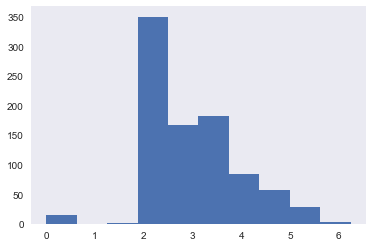

In [44]:
plt.hist(np.log(train['Fare'] + 1))

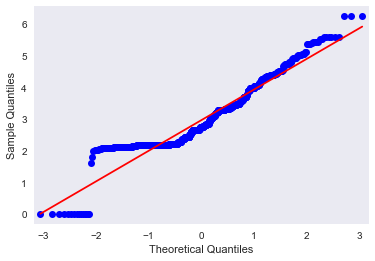

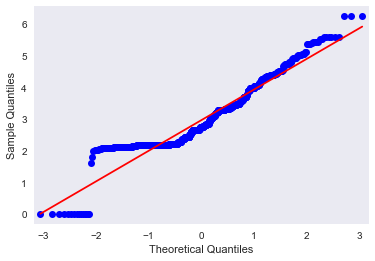

In [45]:
sm.qqplot(np.log(train['Fare'] + 1),line='s') #pretty lose to normal => normalizong

In [46]:
#doing a normalization
test.iloc[get_null_rows(test,'Fare')] = train['Fare'].mean()
log_fare = np.log(train['Fare'] + 1)
log_fare_mean = log_fare.mean()
log_fare_std = log_fare.std() 
log_fare = (log_fare - log_fare_mean) / log_fare_std

train['Fare'] = log_fare

### dealing with Age

In [47]:
np.sum(train['Age'].isnull())

177

29.6420926966
28.0


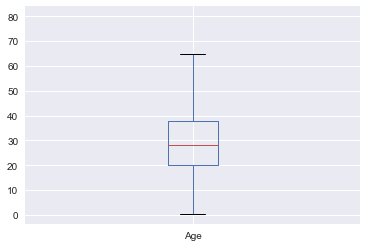

In [48]:
train.boxplot(column='Age')
print(np.mean(train[~train['Age'].isnull()]['Age'])  ## the mean)
print(np.median(train[~train['Age'].isnull()]['Age'])  ## the median)

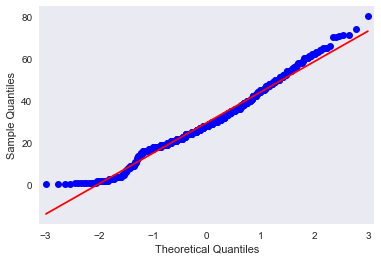

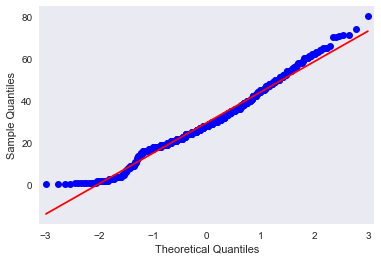

In [49]:
sm.qqplot(train[~train['Age'].isnull()]['Age'],line='s')  # checking if normal distributed with null values

### Checking correlated variable

In [50]:
train.corr()

,Sex,Age,Fare,Embarked_S,Embarked_C,Embarked_Q,Pclass_3,Pclass_1,Pclass_2,Parch <= 0,0< Parch <= 1,1< Parch <= 2,2< Parch <= 3,Parch >= 4,SibSp <= 0,0< SibSp <= 1,1< SibSp <= 2,SibSp >= 3
Sex,1.000000,0.099037,-0.259943,0.121405,-0.084520,-0.075217,0.134227,-0.093142,-0.066459,0.249837,-0.129117,-0.172326,-0.070759,-0.078005,0.205817,-0.181466,-0.042821,-0.051668
Age,0.099037,1.000000,0.111644,-0.025431,0.038268,-0.021693,-0.309944,0.344976,0.009214,0.279417,-0.154073,-0.278781,0.020659,0.099369,0.160784,0.018179,-0.092493,-0.310616
Fare,-0.259943,0.111644,1.000000,-0.131274,0.264665,-0.159843,-0.537449,0.661297,-0.038179,-0.368525,0.202167,0.274542,0.023431,0.079561,-0.396447,0.302196,0.099554,0.176700
Embarked_S,0.121405,-0.025431,-0.131274,1.000000,-0.782613,-0.499261,-0.013594,-0.165022,0.190824,-0.033624,-0.025824,0.061998,0.012723,0.041916,-0.005362,-0.038004,-0.018500,0.098619
Embarked_C,-0.084520,0.038268,0.264665,-0.782613,1.000000,-0.148646,-0.154785,0.299472,-0.126039,-0.031962,0.065215,-0.011227,0.002118,-0.051486,-0.034046,0.091498,0.011658,-0.112759
Embarked_Q,-0.075217,-0.021693,-0.159843,-0.499261,-0.148646,1.000000,0.237035,-0.154680,-0.127705,0.097900,-0.049747,-0.082861,-0.023159,0.005076,0.055905,-0.066981,0.013162,0.000284
Pclass_3,0.134227,-0.309944,-0.537449,-0.013594,-0.154785,0.237035,1.000000,-0.625395,-0.567432,0.040496,-0.067821,-0.009363,0.007213,0.074580,0.079167,-0.173007,-0.006017,0.169463
Pclass_1,-0.093142,0.344976,0.661297,-0.165022,0.299472,-0.154680,-0.625395,1.000000,-0.287653,-0.010644,0.020124,0.016020,-0.042346,-0.035108,-0.061432,0.128371,-0.026215,-0.095894
Pclass_2,-0.066459,0.009214,-0.038179,0.190824,-0.126039,-0.127705,-0.567432,-0.287653,1.000000,-0.038473,0.062006,-0.005413,0.035832,-0.054490,-0.032343,0.076883,0.035049,-0.106804
Parch <= 0,0.249837,0.279417,-0.368525,-0.033624,-0.031962,0.097900,0.040496,-0.010644,-0.038473,1.000000,-0.696943,-0.560214,-0.133981,-0.190016,0.419741,-0.223256,-0.079841,-0.392354


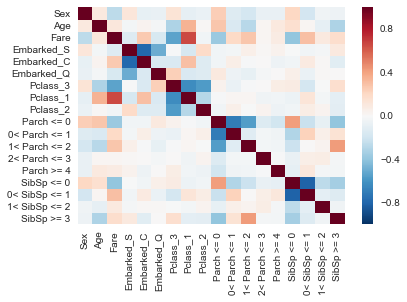

In [51]:
sns.heatmap(train.corr()) #Pclass_1 and Fare are correlated => removing Pclass_1

In [52]:
train = train.drop('Pclass_1',axis = 1)

### Option 1- replace with mean since looks like normal

In [49]:
## replacing null with mean values
train.iloc[get_null_rows(train,'Age')] = np.mean(train[~train['Age'].isnull()]['Age'])
test.iloc[get_null_rows(test,'Age')] = np.mean(train[~train['Age'].isnull()]['Age'])
age_mean =  train['Age'].mean()
age_std = train['Age'].std()

In [50]:
## normalizing (standardizing)
train['Age'] = (train['Age'] - age_mean) /  age_std

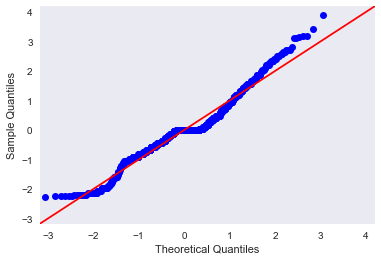

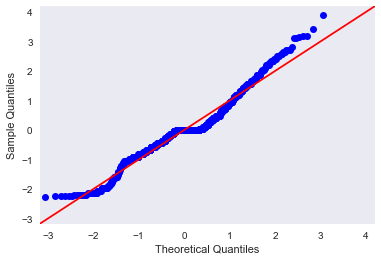

In [51]:
sm.qqplot(train['Age'],line='45')

### Option 2 - predicting Age (averaging on ridge, lasso, svm, RF, gradient boosting  (on training set alone))

### Age as 'y'

In [53]:
y_no_age = train[~train['Age'].isnull()]['Age']
y_test_age = train[train['Age'].isnull()]['Age']

In [54]:
X_no_age = train[~train['Age'].isnull()]
X_test_age = train[train['Age'].isnull()]
X_no_age = X_no_age.drop('Age',1)
X_test_age = X_test_age.drop('Age',1)

#### Ridge

In [55]:
param_grid = {'alpha':np.logspace(-4,1,num=6)}
Ridge_age = get_best_model(Ridge(random_state=1),X_no_age,y_no_age,params=param_grid,cv=50)
Ridge_age.fit(X_no_age,y_no_age)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001)

#### Lasso

In [56]:
param_grid = {'alpha':np.logspace(-4,1,num=6)}
Lasso_age = get_best_model(Lasso(random_state=1),X_no_age,y_no_age,params=param_grid,cv=50)
Lasso_age.fit(X_no_age,y_no_age)

C:\Users\galkampel.DESKTOP-KTJUKIM\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

#### SVR

In [57]:
param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)}
SVR_age = get_best_model(SVR(kernel='rbf', gamma=0.1),X_no_age,y_no_age,params=param_grid,cv=50)
SVR_age.fit(X_no_age,y_no_age)

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.10000000000000001, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

#### RF

In [58]:
param_grid={"criterion": ["mse", "mae"]}
RF_age = get_best_model(RandomForestRegressor(random_state=1),X_no_age,y_no_age,params=param_grid,cv=50)
RF_age.fit(X_no_age,y_no_age)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

#### GB

In [59]:
param_grid={'max_depth':range(3,10,2), 'learning_rate':[0.001,0.01,0.1] }
GB_age = get_best_model(GradientBoostingRegressor(random_state=1),X_no_age,y_no_age,params=param_grid,cv=50)
GB_age.fit(X_no_age,y_no_age)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

#### predict using the average of the models

In [60]:
pred_age = (Ridge_age.predict(X_test_age) + Lasso_age.predict(X_test_age) + SVR_age.predict(X_test_age) \
+ RF_age.predict(X_test_age) + GB_age.predict(X_test_age) ) / 5

### filling Nan in training set

In [61]:
train.loc[train['Age'].isnull(),'Age'] = pred_age

### looking for outliers

### isolation forest -isolating observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. 


### Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality and our decision function. Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [62]:
clf = IsolationForest(random_state=np.random.RandomState(2))
clf.fit(train)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x000000001225C0D8>,
        verbose=0)

In [63]:
y_s = clf.predict(train)
y_1 = (y_s == 1)  

In [64]:
(y_1 == False).sum() ## there are 89 outliers

89

### PCA

In [65]:
pca = PCA(n_components=2)

In [66]:
model  = pca.fit(train)

In [67]:
model.explained_variance_ratio_.sum() #explained variance is low

0.9911536276856262

In [68]:
regulars = train.loc[y_1,:]
outliers = train.loc[~y_1,:]

In [69]:
PC1_regular = np.dot(regulars,model.components_[0])
PC2_regular = np.dot(regulars,model.components_[1])

PC1_outlier = np.dot(outliers,model.components_[0])
PC2_outlier = np.dot(outliers,model.components_[1])

In [70]:
np.where(PC1_regular < -2)[0]

array([], dtype=int64)

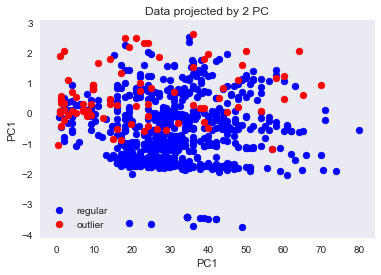

In [71]:
plt.figure()
plt.scatter(PC1_regular,PC2_regular,color = 'b', label = 'regular')
plt.scatter(PC1_outlier,PC2_outlier,color = 'r',label = 'outlier')
plt.legend(loc='lower left')
plt.xlabel("PC1")
plt.ylabel("PC1")
plt.title("Data projected by 2 PC")
## oulier detection does not look good according to the plot

### preparing test for modeling

In [72]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [73]:
test = test.drop(['PassengerId','Name','Cabin','Ticket'],1)
test['Sex'] = test['Sex'].map(lambda val: 1 if val =='male'  else 0 )
test = att_to_dummy(test,'Embarked',embarked,new_vals1)
test = att_to_dummy(test,'Pclass',pcalss,new_vals2)

split_to_ranges(test,'Parch',[0,1,2,3,4])
test = test.drop(['Parch'],axis=1)

split_to_ranges(test,'SibSp',[0,1,2,3])
test = test.drop(['SibSp'],axis=1)

test = test.drop(['Pclass_1'],axis=1) #remove because of correlation

In [74]:
test.columns

Index([u'Sex', u'Age', u'Fare', u'Embarked_S', u'Embarked_C', u'Embarked_Q',
       u'Pclass_3', u'Pclass_2', u'Parch <= 0', u'0< Parch <= 1',
       u'1< Parch <= 2', u'2< Parch <= 3', u'Parch >= 4', u'SibSp <= 0',
       u'0< SibSp <= 1', u'1< SibSp <= 2', u'SibSp >= 3'],
      dtype='object')

In [75]:
log_fare_2 = np.log(test['Fare'] + 1)
log_fare_2 = (log_fare_2  - log_fare_mean) / log_fare_std
test['Fare'] = log_fare_2

### option 1

In [71]:
test['Age'] = (test['Age'] - age_mean) /  age_std

### option 2

### filling Nan in test set

In [76]:
test_fill_age = test.loc[test['Age'].isnull()].drop('Age',1)

In [77]:
pred_age_test = (Ridge_age.predict(test_fill_age) + Lasso_age.predict(test_fill_age) + SVR_age.predict(test_fill_age) \
+ RF_age.predict(test_fill_age) + GB_age.predict(test_fill_age) ) / 5

In [79]:
test.loc[test['Age'].isnull(),'Age'] = pred_age_test

In [80]:
age_mean =  train['Age'].mean()
age_std = train['Age'].std()
train['Age'] = (train['Age'] - age_mean) /  age_std

In [81]:
test['Age'] = (test['Age'] - age_mean) /  age_std

#### balance the data (SMOTE)

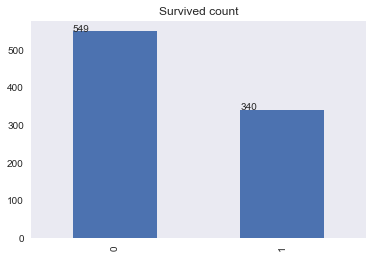

In [82]:
ax = pd.value_counts(y_train, sort = True).sort_index().plot(kind='bar', title="Survived count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

In [83]:
sm = SMOTE(random_state=42)
X_model, y_model = sm.fit_sample(train, y_train)

In [84]:
print('''X before SMOTE: %d
X after SMOTE: %d
y before SMOTE: %d
y after SMOTE: %d
''' %(train.shape[0],X_model.shape[0],len(y_train),len(y_model)))

X before SMOTE: 889
X after SMOTE: 1098
y before SMOTE: 889
y after SMOTE: 1098



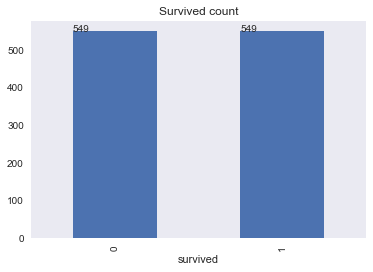

In [85]:
ax = pd.crosstab(index = y_model, columns="count",rownames=['survived']).plot(kind='bar', title="Survived count",legend=False)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

In [86]:
train_cv_size = X_model.shape[0]
train_size = int(train_cv_size * 0.8)
shuffled_indices = np.random.permutation(train_cv_size)

In [87]:
train_x = X_model[shuffled_indices[:train_size],:]
train_y = y_model[shuffled_indices[:train_size]]
val_x = X_model[shuffled_indices[train_size:],:]
val_y = y_model[shuffled_indices[train_size:]]

### modeling (logistic regression, svm, gradient boosting, random forest)

### generate general model and general plot

In [89]:
param_grid = {'C':np.logspace(-4,4,num=9)}
LR_model = get_best_model(LogisticRegression(random_state=1),train_x,train_y,params=param_grid)

The accuracy of best model on validation is 0.790909 
Confusion matrix of best model on validation: 
[[89 24]
 [22 85]]


### SVM

In [93]:
param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)}
SVM_model = get_best_model(SVC(kernel='rbf', gamma=0.1,random_state=1),train_x,train_y,params=param_grid)

The accuracy of best model on validation is 0.818182 
Confusion matrix of best model on validation: 
[[89 24]
 [16 91]]


#### RF

In [94]:
param_grid={"criterion": ["gini", "entropy"]}
RF_model = get_best_model(RandomForestClassifier(random_state=1),train_x,train_y,params=param_grid)

The accuracy of best model on validation is 0.822727 
Confusion matrix of best model on validation: 
[[90 23]
 [16 91]]


#### gradient boosting

In [95]:
param_grid={'max_depth':range(3,10,2), 'learning_rate':[0.001,0.01,0.1] }
GB_model = get_best_model(GradientBoostingClassifier(random_state=1),train_x,train_y,params=param_grid)

The accuracy of best model on validation is 0.818182 
Confusion matrix of best model on validation: 
[[91 22]
 [18 89]]
